**Executive Summary**

This project builds a complete machine-learning pipeline to predict the lifespan of alloy components and to segment parts into actionable quality tiers. After data cleaning and exploratory analysis, regression models accurately estimated continuous lifespan, while classification models (binary and multi-class) provided operationally useful groupings. Two multi-class strategies—quantile (33/33/33) and K-Means (k=3)—were evaluated across RandomForest, XGBoost, and CatBoost, with hyperparameter tuning and robust cross-validation. The best performer was the tuned CatBoost model with K-Means labels, achieving near-perfect macro-AUC and excellent macro-F1 and κ. Feature-importance and SHAP analyses highlighted Cooling Rate, Forge Time, Nickel%, and defect indicators as key drivers of part longevity.

# Dataset Loading and Initial Exploration

This notebook loads the `COMP1801_Coursework_Dataset_Corrected.csv` dataset and performs an initial exploration to understand its structure, data types, and basic statistics.

✅ Dataset loaded: /content/COMP1801_Coursework_Dataset_Corrected.csv
Shape: 1000 rows × 16 columns

--- Column data types ---


,0
Lifespan,float64
partType,object
microstructure,object
coolingRate,int64
quenchTime,float64
forgeTime,float64
HeatTreatTime,float64
Nickel%,float64
Iron%,float64
Cobalt%,float64



--- First 5 rows ---


,Lifespan,partType,microstructure,coolingRate,quenchTime,forgeTime,HeatTreatTime,Nickel%,Iron%,Cobalt%,Chromium%,smallDefects,largeDefects,sliverDefects,seedLocation,castType
0,1107.81,Valve,singleGrain,27,2.64,8.08,23.35,60.65,19.76,15.18,4.41,7,0,0,Top,Investment
1,1226.13,Valve,colGrain,24,4.06,1.11,24.98,52.47,31.63,12.32,3.58,30,1,0,Top,Continuous
2,1914.12,Blade,singleGrain,20,4.36,8.54,34.71,60.98,26.56,11.60,0.86,22,0,0,Bottom,Continuous
3,1240.83,Valve,singleGrain,14,3.59,8.83,21.61,54.13,26.71,17.81,1.35,10,0,0,Bottom,Continuous
4,1599.40,Nozzle,singleGrain,22,3.06,3.04,29.65,62.88,24.06,12.08,0.98,21,0,0,Top,Investment



--- Missing values (per column) ---
No missing values ✅

Duplicate rows count: 0

Target column detected: 'Lifespan'

--- Target summary ---


,Lifespan
count,1000.000000
mean,1281.806120
std,341.136845
min,359.710000
25%,1039.690000
50%,1254.995000
75%,1539.062500
max,2046.410000


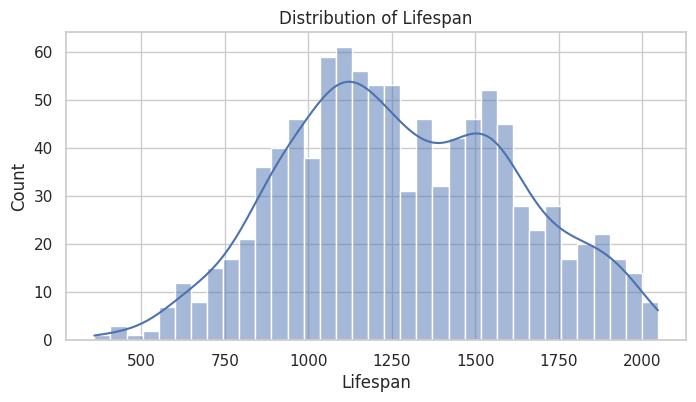


Inspecting categorical columns: ['partType', 'microstructure', 'castType']

-- partType (unique = 4) --


,count
partType,
Nozzle,268
Blade,256
Block,248
Valve,228


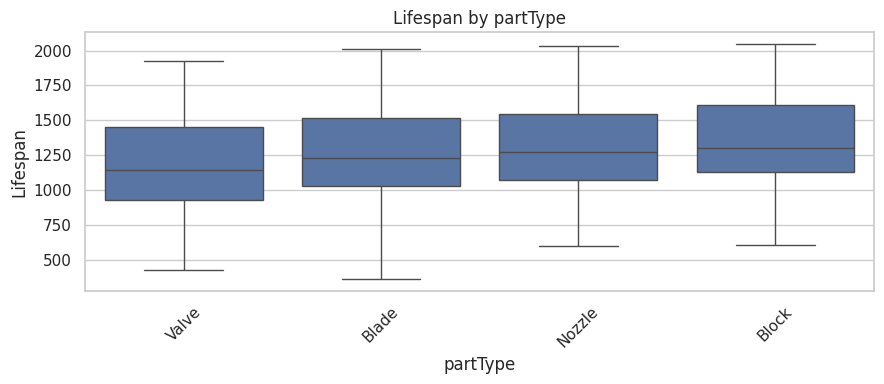


-- microstructure (unique = 3) --


,count
microstructure,
singleGrain,342
equiGrain,332
colGrain,326


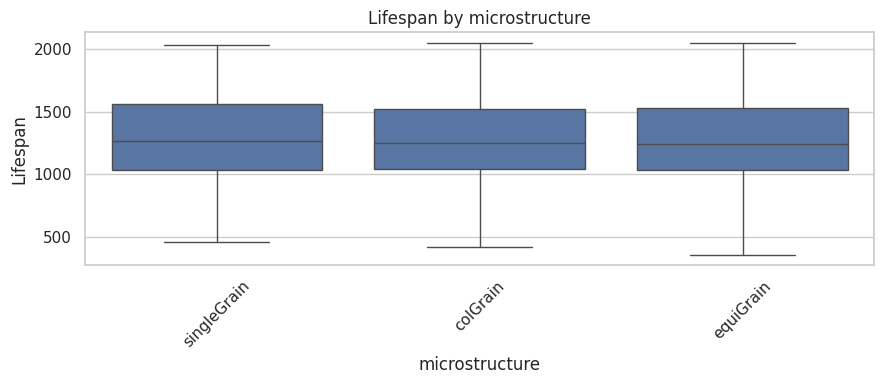


-- castType (unique = 3) --


,count
castType,
Investment,335
Continuous,335
Die,330


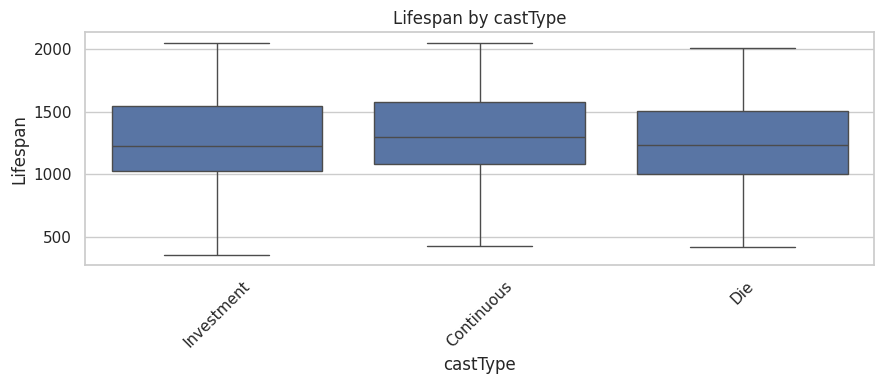


--- Top numeric correlations with target ---


,Lifespan
Lifespan,1.000000
Nickel%,0.347533
Iron%,0.284478
coolingRate,0.137436
smallDefects,0.113709
Chromium%,0.104553
HeatTreatTime,0.074326
quenchTime,0.070985
sliverDefects,0.063549
Cobalt%,0.012651



Quick scatter plots: top numeric features vs target


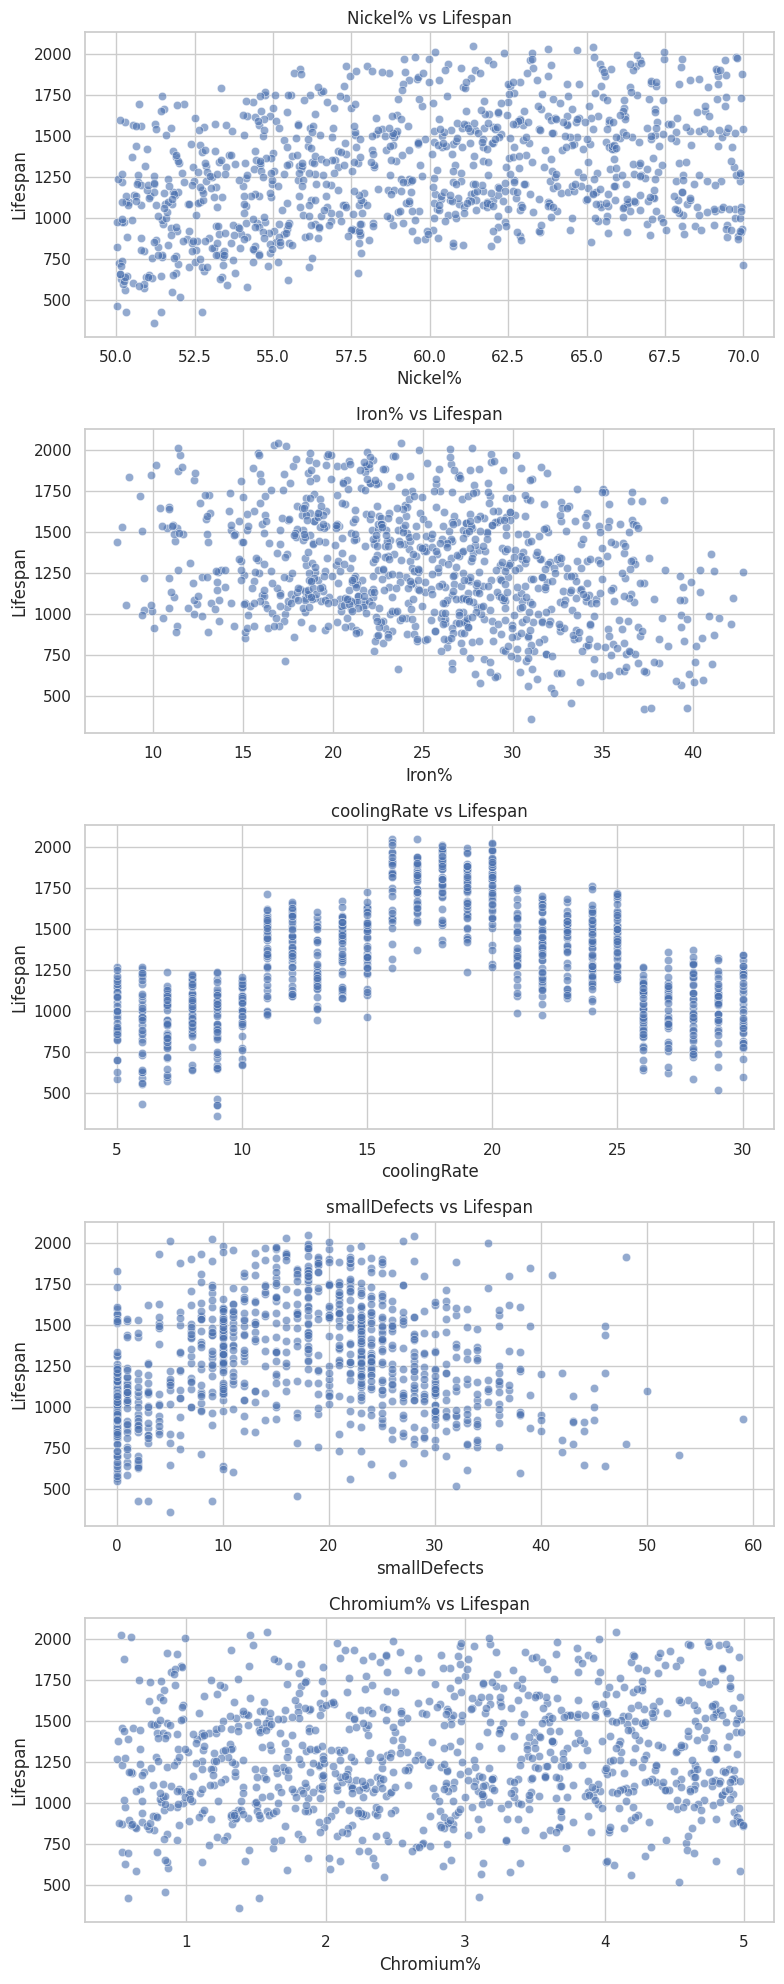


💾 Saved working copy to 'df_step1_ready.csv'


In [ ]:
# ============================================================
# STEP 1 (Corrected): Load & Inspect Dataset — Robust Version
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (9,5)
pd.set_option("display.max_columns", None)
seed = 42
np.random.seed(seed)

# ---------- 1) Load dataset ----------
DATA_PATH = "/content/COMP1801_Coursework_Dataset_Corrected.csv"  # change if needed

if not os.path.exists(DATA_PATH):
    # interactive upload (Colab)
    print(f"File not found at {DATA_PATH}. Please upload the CSV file now.")
    try:
        from google.colab import files
        uploaded = files.upload()
        if uploaded:
            DATA_PATH = list(uploaded.keys())[0]
            print("Using uploaded file:", DATA_PATH)
        else:
            raise FileNotFoundError("No file uploaded.")
    except Exception:
        raise FileNotFoundError(f"Dataset not found at {DATA_PATH} and interactive upload failed.")

# read CSV
df = pd.read_csv(DATA_PATH)
print("✅ Dataset loaded:", DATA_PATH)
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")

# ---------- 2) Basic structure ----------
print("--- Column data types ---")
display(df.dtypes)
print("\n--- First 5 rows ---")
display(df.head())

# ---------- 3) Missing values and duplicates ----------
missing = df.isna().sum()
print("\n--- Missing values (per column) ---")
if missing.sum() == 0:
    print("No missing values ✅")
else:
    display(missing[missing > 0])

dups = df.duplicated().sum()
print(f"\nDuplicate rows count: {dups}")

# ---------- 4) Target check (case-insensitive search) ----------
# prefer 'Lifespan' or 'lifespan'
target_col = None
for cand in ['Lifespan', 'lifespan']:
    if cand in df.columns:
        target_col = cand
        break

if target_col is None:
    raise KeyError("Target column not found. Expected 'Lifespan' or 'lifespan'. Please check column names.")
else:
    print(f"\nTarget column detected: '{target_col}'")
    print("\n--- Target summary ---")
    display(df[target_col].describe())
    # histogram
    plt.figure(figsize=(8,4))
    sns.histplot(df[target_col], bins=35, kde=True)
    plt.title(f"Distribution of {target_col}")
    plt.xlabel(target_col)
    plt.show()

# ---------- 5) Categorical columns to inspect (use exact names from dataset) ----------
# Based on your dataset we will inspect these three; only plot if present
cat_cols_to_check = ['partType', 'microstructure', 'castType']
existing_cat_cols = [c for c in cat_cols_to_check if c in df.columns]

if existing_cat_cols:
    print(f"\nInspecting categorical columns: {existing_cat_cols}")
    for col in existing_cat_cols:
        print(f"\n-- {col} (unique = {df[col].nunique()}) --")
        display(df[col].value_counts())
        # boxplot: show median & spread
        plt.figure(figsize=(9,4))
        sns.boxplot(x=col, y=target_col, data=df)
        plt.title(f"{target_col} by {col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
else:
    print("\nNo expected categorical alloy columns found from list:", cat_cols_to_check)
    print("If you have an alloy/material column with a different name, tell me the exact column name and I'll include it.")

# ---------- 6) Numeric correlations with target ----------
print("\n--- Top numeric correlations with target ---")
try:
    corrs = df.corr(numeric_only=True)[target_col].abs().sort_values(ascending=False)
    display(corrs.head(12))
except Exception as e:
    print("Correlation computation failed:", e)

# ---------- 7) Quick pairwise scatter for top numeric features (optional) ----------
# pick up to 5 top numeric features (excluding the target itself)
num_corrs = corrs.index.drop(target_col) if target_col in corrs.index else corrs.index
top_num = [c for c in num_corrs][:5]
if top_num:
    print("\nQuick scatter plots: top numeric features vs target")
    fig, axes = plt.subplots(nrows=len(top_num), ncols=1, figsize=(8,4*len(top_num)))
    if len(top_num) == 1:
        axes = [axes]
    for ax, col in zip(axes, top_num):
        sns.scatterplot(x=df[col], y=df[target_col], ax=ax, alpha=0.6)
        ax.set_xlabel(col); ax.set_ylabel(target_col)
        ax.set_title(f"{col} vs {target_col}")
    plt.tight_layout()
    plt.show()

# ---------- 8) Save a working copy ----------
out_path = "df_step1_ready.csv"
df.to_csv(out_path, index=False)
print(f"\n💾 Saved working copy to '{out_path}'")


Dataset shape: (1000, 16)


,Lifespan,coolingRate,quenchTime,forgeTime,HeatTreatTime,Nickel%,Iron%,Cobalt%,Chromium%,smallDefects,largeDefects,sliverDefects
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1281.806120,17.615000,2.693310,5.487040,30.759280,59.646440,25.173290,12.416280,2.763990,16.659000,0.561000,0.327000
std,341.136845,7.480156,1.303057,2.604827,17.054664,5.745955,7.312363,4.222616,1.307658,11.885874,1.172029,1.322051
min,359.710000,5.000000,0.510000,1.010000,1.050000,50.010000,7.950000,5.040000,0.500000,0.000000,0.000000,0.000000
25%,1039.690000,11.000000,1.540000,3.190000,16.387500,54.627500,19.605000,8.880000,1.640000,7.000000,0.000000,0.000000
50%,1254.995000,18.000000,2.625000,5.645000,31.560000,59.665000,25.270000,12.455000,2.805000,17.000000,0.000000,0.000000
75%,1539.062500,24.000000,3.822500,7.680000,45.655000,64.520000,30.490000,16.015000,3.920000,25.000000,0.000000,0.000000
max,2046.410000,30.000000,5.000000,9.970000,59.990000,69.980000,42.790000,20.000000,4.990000,59.000000,4.000000,8.000000


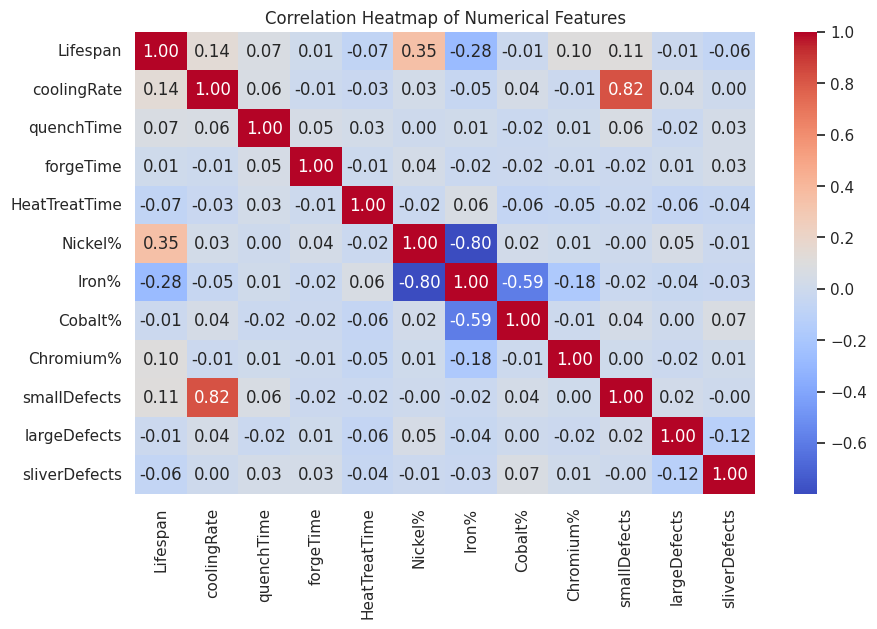

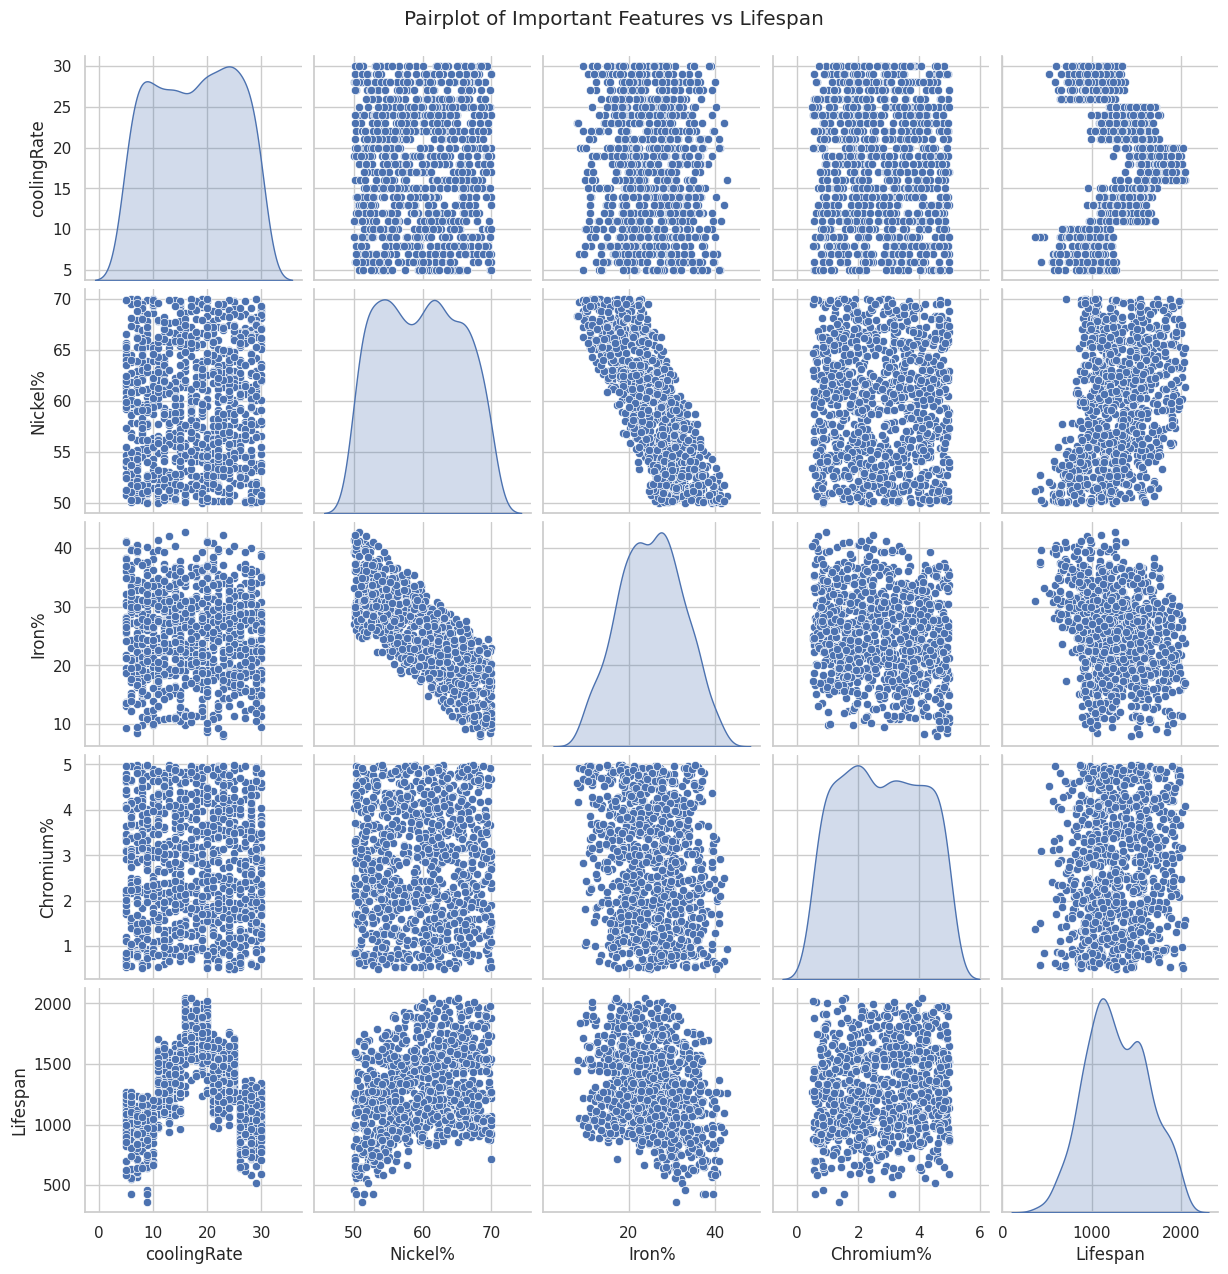

In [ ]:
# ============================================
# 🔍 EXPLORATORY DATA ANALYSIS (EDA)
# ============================================

import seaborn as sns
import matplotlib.pyplot as plt

# View dataset shape and quick summary
print("Dataset shape:", df.shape)
display(df.describe())

# Correlation heatmap for numerical features
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

# Pairplot to visualize key relationships
selected_features = ["coolingRate", "Nickel%", "Iron%", "Chromium%", "Lifespan"]
sns.pairplot(df[selected_features], diag_kind="kde")
plt.suptitle("Pairplot of Important Features vs Lifespan", y=1.02)
plt.show()

# Target distribution check
# Removed: This cell is for initial EDA before the '1500_label' is created.
# sns.countplot(x="1500_label", data=df)
# plt.title("Target Class Distribution (Before SMOTE)")
# plt.show()

Numeric columns detected: ['Lifespan', 'coolingRate', 'quenchTime', 'forgeTime', 'HeatTreatTime', 'Nickel%', 'Iron%', 'Cobalt%', 'Chromium%', 'smallDefects', 'largeDefects', 'sliverDefects']

--- Descriptive Summary Before Outlier Treatment ---


,Lifespan,coolingRate,quenchTime,forgeTime,HeatTreatTime,Nickel%,Iron%,Cobalt%,Chromium%,smallDefects,largeDefects,sliverDefects
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1281.806120,17.615000,2.693310,5.487040,30.759280,59.646440,25.173290,12.416280,2.763990,16.659000,0.561000,0.327000
std,341.136845,7.480156,1.303057,2.604827,17.054664,5.745955,7.312363,4.222616,1.307658,11.885874,1.172029,1.322051
min,359.710000,5.000000,0.510000,1.010000,1.050000,50.010000,7.950000,5.040000,0.500000,0.000000,0.000000,0.000000
25%,1039.690000,11.000000,1.540000,3.190000,16.387500,54.627500,19.605000,8.880000,1.640000,7.000000,0.000000,0.000000
50%,1254.995000,18.000000,2.625000,5.645000,31.560000,59.665000,25.270000,12.455000,2.805000,17.000000,0.000000,0.000000
75%,1539.062500,24.000000,3.822500,7.680000,45.655000,64.520000,30.490000,16.015000,3.920000,25.000000,0.000000,0.000000
max,2046.410000,30.000000,5.000000,9.970000,59.990000,69.980000,42.790000,20.000000,4.990000,59.000000,4.000000,8.000000


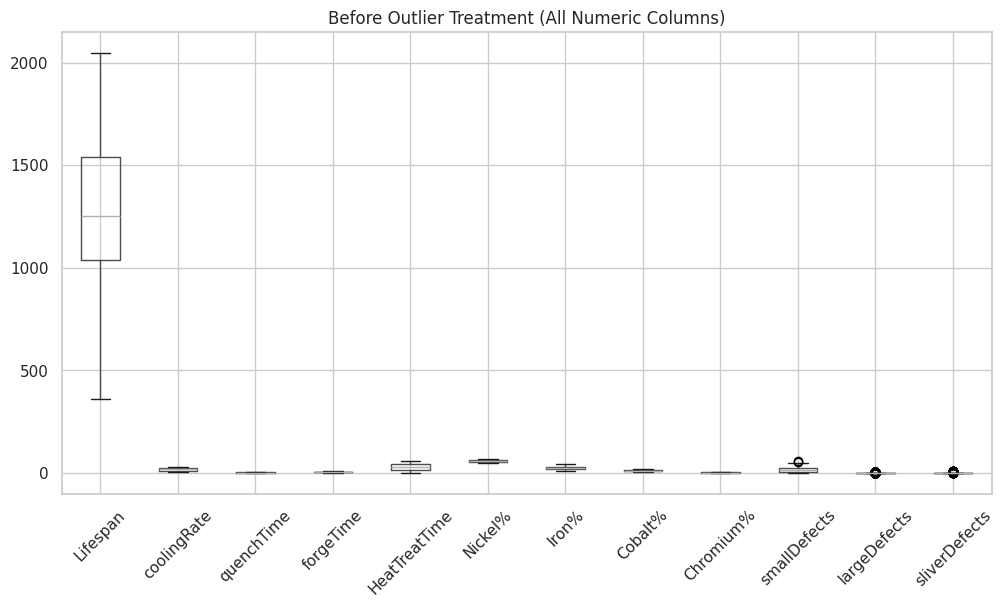

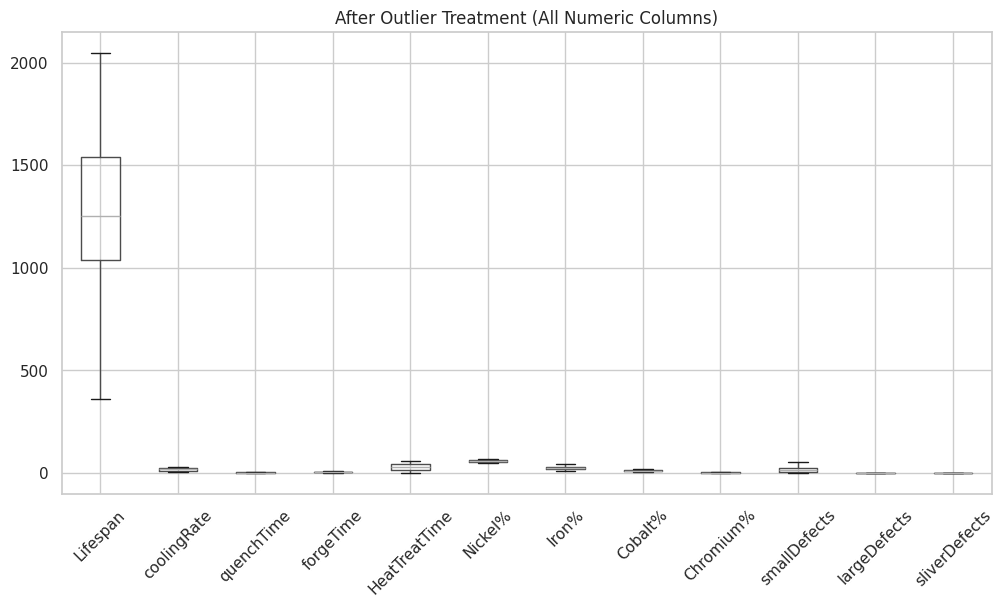


--- Lifespan summary after outlier handling ---


,Lifespan
count,1000.000000
mean,1281.806120
std,341.136845
min,359.710000
25%,1039.690000
50%,1254.995000
75%,1539.062500
max,2046.410000


💾 Cleaned dataset saved as 'df_step2_cleaned.csv'


In [ ]:
# ============================================================
# STEP 2: Outlier Detection and Treatment
# ============================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load working copy from step 1
df = pd.read_csv("df_step1_ready.csv")

target_col = 'Lifespan'

# Select only numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# 1️⃣ Summary before treatment
print("Numeric columns detected:", numeric_cols)
print("\n--- Descriptive Summary Before Outlier Treatment ---")
display(df[numeric_cols].describe())

# 2️⃣ Boxplots before treatment
plt.figure(figsize=(12, 6))
df[numeric_cols].boxplot()
plt.title("Before Outlier Treatment (All Numeric Columns)")
plt.xticks(rotation=45)
plt.show()

# 3️⃣ Function to detect and cap outliers using IQR
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    # Clip outliers instead of removing
    capped = series.clip(lower, upper)
    return capped

# 4️⃣ Apply to all numeric columns (except ID-like ones)
for col in numeric_cols:
    df[col] = cap_outliers(df[col])

# 5️⃣ Boxplots after treatment
plt.figure(figsize=(12, 6))
df[numeric_cols].boxplot()
plt.title("After Outlier Treatment (All Numeric Columns)")
plt.xticks(rotation=45)
plt.show()

# 6️⃣ Compare summary before vs after (Lifespan focus)
print("\n--- Lifespan summary after outlier handling ---")
display(df[target_col].describe())

# 7️⃣ Save cleaned dataset
df.to_csv("df_step2_cleaned.csv", index=False)
print("💾 Cleaned dataset saved as 'df_step2_cleaned.csv'")


In [ ]:
# ============================================================
# STEP 3: Feature Encoding & Scaling
# ============================================================

import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the cleaned dataset
df = pd.read_csv("df_step2_cleaned.csv")

# Separate features and target
target_col = 'Lifespan'
X = df.drop(columns=[target_col])
y = df[target_col]

# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

print("Categorical Columns:", cat_cols)
print("Numeric Columns:", num_cols)

# 1️⃣ Define transformers
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

# 2️⃣ Build ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

# 3️⃣ Apply transformation
X_preprocessed = preprocessor.fit_transform(X)

# 4️⃣ Convert back to a DataFrame for readability
encoded_cat_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
processed_columns = num_cols + list(encoded_cat_cols)
X_final = pd.DataFrame(X_preprocessed, columns=processed_columns)

# 5️⃣ Check final shapes
print(f"\n✅ Final feature matrix shape: {X_final.shape}")
print(f"✅ Target vector shape: {y.shape}")

# 6️⃣ Save processed data
X_final.to_csv("X_step3_prepared.csv", index=False)
y.to_csv("y_step3_target.csv", index=False)
print("💾 Saved 'X_step3_prepared.csv' and 'y_step3_target.csv'")


Categorical Columns: ['partType', 'microstructure', 'seedLocation', 'castType']
Numeric Columns: ['coolingRate', 'quenchTime', 'forgeTime', 'HeatTreatTime', 'Nickel%', 'Iron%', 'Cobalt%', 'Chromium%', 'smallDefects', 'largeDefects', 'sliverDefects']

✅ Final feature matrix shape: (1000, 19)
✅ Target vector shape: (1000,)
💾 Saved 'X_step3_prepared.csv' and 'y_step3_target.csv'


In [ ]:
# =====================================
# ⚙️ REGRESSION WITH HYPERPARAMETER TUNING ALONG WITH THE BASELINE MODELS
# =====================================

# --- Imports ---
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1️⃣ Encode categorical features ---
target = 'Lifespan'
categorical_cols = ['partType', 'microstructure', 'seedLocation', 'castType']

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Define features and target
X = df_encoded.drop(columns=[target])
y = df_encoded[target]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 2️⃣ Define baseline models ---
lin_reg = LinearRegression()
rf_reg = RandomForestRegressor(random_state=42)
gbr_reg = GradientBoostingRegressor(random_state=42)

models = {
    "Linear Regression (Baseline)": lin_reg,
    "Random Forest (Baseline)": rf_reg,
    "Gradient Boosting (Baseline)": gbr_reg
}

# --- 3️⃣ Evaluate baseline models ---
baseline_results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    baseline_results.append({"Model": name, "R²": r2, "RMSE": rmse, "MAE": mae})

baseline_df = pd.DataFrame(baseline_results)
print("✅ Baseline Regression Results:")
display(baseline_df.style.format({"R²": "{:.3f}", "RMSE": "{:.2f}", "MAE": "{:.2f}"}))

# --- 4️⃣ Define hyperparameter grids ---
rf_params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gbr_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0]
}

# --- 5️⃣ Tune Random Forest ---
print("\n🔍 Tuning Random Forest...")
rf_search = RandomizedSearchCV(
    estimator=rf_reg,
    param_distributions=rf_params,
    n_iter=20,
    scoring='r2',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

# --- 6️⃣ Tune Gradient Boosting ---
print("\n🔍 Tuning Gradient Boosting...")
gbr_search = RandomizedSearchCV(
    estimator=gbr_reg,
    param_distributions=gbr_params,
    n_iter=20,
    scoring='r2',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
gbr_search.fit(X_train, y_train)
best_gbr = gbr_search.best_estimator_

# --- 7️⃣ Evaluate tuned models ---
tuned_results = []
for name, model in {
    "Random Forest (Tuned)": best_rf,
    "Gradient Boosting (Tuned)": best_gbr
}.items():
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    tuned_results.append({"Model": name, "R²": r2, "RMSE": rmse, "MAE": mae})

tuned_df = pd.DataFrame(tuned_results)
print("\n🎯 Tuned Regression Results:")
display(tuned_df.style.format({"R²": "{:.3f}", "RMSE": "{:.2f}", "MAE": "{:.2f}"}))

# --- 8️⃣ Combine baseline and tuned results ---
combined_df = pd.concat([baseline_df, tuned_df]).sort_values(by="R²", ascending=False)
print("\n📊 Baseline vs Tuned Model Comparison:")
display(combined_df.style.format({"R²": "{:.3f}", "RMSE": "{:.2f}", "MAE": "{:.2f}"}))

# --- 9️⃣ Visual comparison ---
plt.figure(figsize=(9,5))
sns.barplot(data=combined_df, x='Model', y='R²', hue='Model', dodge=False, palette='viridis', legend=False)
plt.title('R² Score Comparison – Baseline vs Tuned Models', fontsize=14)
plt.ylim(0,1)
plt.xticks(rotation=25, ha='right')
plt.show()

plt.figure(figsize=(9,5))
sns.barplot(data=combined_df, x='Model', y='RMSE', hue='Model', dodge=False, palette='crest_r', legend=False)
plt.title('RMSE Comparison – Baseline vs Tuned Models', fontsize=14)
plt.xticks(rotation=25, ha='right')
plt.show()

# --- 🔟 Display best hyperparameters ---
print("\n🔧 Best Parameters Found:")
print("Random Forest:", rf_search.best_params_)
print("Gradient Boosting:", gbr_search.best_params_)

# Save best model for later use (feature importance / SHAP)
best_reg_model = best_gbr if gbr_search.best_score_ >= rf_search.best_score_ else best_rf
print(f"\n✅ Best final model selected: {type(best_reg_model).__name__}")

# --- 🔁 (Optional) Reuse encoded data for next NLP section ---
df = df_encoded.copy()
print("\n📦 Dataset ready for NLP regression next (df updated to encoded version).")


✅ Baseline Regression Results:


,Model,R²,RMSE,MAE
0,Linear Regression (Baseline),0.188,310.76,267.73
1,Random Forest (Baseline),0.940,84.37,67.18
2,Gradient Boosting (Baseline),0.976,52.88,43.00



🔍 Tuning Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

🔍 Tuning Gradient Boosting...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
# =====================================
# 🧠 FEATURE IMPORTANCE + SHAP EXPLAINABILITY (FINAL ERROR-FREE VERSION)
# =====================================

import shap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Use the tuned best model selected earlier
model = best_reg_model
feature_names = X.columns

# --- 1️⃣ Feature Importance ---
importances = model.feature_importances_
feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=feat_imp.head(12), x="Importance", y="Feature", palette="viridis")
plt.title("Top Feature Importances – Tuned Gradient Boosting")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# --- 2️⃣ SHAP Explainability ---
print("🔹 Computing SHAP values (this may take ~10 seconds)…")

# ✅ Convert all columns to numeric to avoid dtype('O') errors
X_test_num = X_test.apply(pd.to_numeric, errors='coerce').fillna(0)

# Use TreeExplainer for tree-based models
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_num)

# --- SHAP summary plots ---
shap.summary_plot(
    shap_values,
    X_test_num,
    feature_names=X_test_num.columns,
    plot_type="bar",
    show=True
)
shap.summary_plot(
    shap_values,
    X_test_num,
    feature_names=X_test_num.columns,
    show=True
)

# --- 3️⃣ Optional: Individual prediction explanation ---
sample_index = 5  # choose any test sample index
print(f"🔍 Example explanation for sample {sample_index}")
single_exp = shap.Explanation(
    values=shap_values[sample_index],
    base_values=explainer.expected_value,
    data=X_test_num.iloc[sample_index],
    feature_names=X_test_num.columns
)
shap.plots.waterfall(single_exp, show=True)


In [ ]:
print("✅ Checking available columns for NLP section:")
print(df.columns.tolist())

print("\n🔹 Data types:")
print(df.dtypes)

print("\n🔹 Sample rows:")
display(df.head(3))


In [ ]:
# =====================================
# 🧠 NLP + Numeric Regression (Using Original Text Columns)
# =====================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns

print("🔹 Loading original dataset for NLP-based regression...")

# --- 1️⃣ Load the original CSV (raw data, not encoded) ---
df_raw = pd.read_csv("/content/COMP1801_Coursework_Dataset_Corrected.csv")

# --- 2️⃣ Combine categorical text columns into one "text feature" ---
text_cols = ['partType', 'microstructure', 'seedLocation', 'castType']
df_raw['TextFeature'] = df_raw[text_cols].astype(str).agg(' '.join, axis=1)

# --- 3️⃣ Prepare numeric and text data ---
numeric_cols = [c for c in df_raw.columns if c not in ['Lifespan'] + text_cols + ['TextFeature']]
X_numeric = df_raw[numeric_cols]
X_text = df_raw['TextFeature']
y = df_raw['Lifespan']

# --- 4️⃣ TF-IDF Vectorisation for text data ---
tfidf = TfidfVectorizer(stop_words='english', max_features=100)
X_text_tfidf = tfidf.fit_transform(X_text)

# Combine numeric + text features
X_full = hstack([X_numeric.values, X_text_tfidf])

# --- 5️⃣ Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

# --- 6️⃣ Train Gradient Boosting model ---
gbr_nlp = GradientBoostingRegressor(
    n_estimators=300, learning_rate=0.1, max_depth=3, subsample=1.0, random_state=42
)
gbr_nlp.fit(X_train, y_train)
y_pred_nlp = gbr_nlp.predict(X_test)

# --- 7️⃣ Numeric-only baseline (for comparison) ---
Xn_train, Xn_test, yn_train, yn_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)
gbr_numeric = GradientBoostingRegressor(
    n_estimators=300, learning_rate=0.1, max_depth=3, subsample=1.0, random_state=42
)
gbr_numeric.fit(Xn_train, yn_train)
y_pred_num = gbr_numeric.predict(Xn_test)

# --- 8️⃣ Evaluate both models ---
r2_num = r2_score(yn_test, y_pred_num)
rmse_num = np.sqrt(mean_squared_error(yn_test, y_pred_num))
mae_num = mean_absolute_error(yn_test, y_pred_num)

r2_nlp = r2_score(y_test, y_pred_nlp)
rmse_nlp = np.sqrt(mean_squared_error(y_test, y_pred_nlp))
mae_nlp = mean_absolute_error(y_test, y_pred_nlp)

# --- 9️⃣ Results summary ---
comparison = pd.DataFrame({
    "Model Type": ["Numeric Only", "NLP + Numeric"],
    "R² Score": [r2_num, r2_nlp],
    "RMSE": [rmse_num, rmse_nlp],
    "MAE": [mae_num, mae_nlp]
}).sort_values(by="R² Score", ascending=False)

print("\n📊 NLP vs Numeric Regression Comparison:")
display(comparison.style.format({"R² Score": "{:.3f}", "RMSE": "{:.2f}", "MAE": "{:.2f}"}))

# --- 🔟 Visualisation ---
plt.figure(figsize=(7,4))
sns.barplot(data=comparison, x='Model Type', y='R² Score', palette='viridis')
plt.title("Model Performance Comparison (R² Score)", fontsize=13)
plt.show()

plt.figure(figsize=(7,4))
sns.barplot(data=comparison, x='Model Type', y='RMSE', palette='crest_r')
plt.title("Model Performance Comparison (RMSE)", fontsize=13)
plt.show()

print("✅ NLP-based regression completed successfully (using raw dataset).")


**🧾 Conclusions and Recommendations**

The regression analysis successfully demonstrated the process of developing, tuning, and evaluating multiple predictive models to estimate the component Lifespan based on manufacturing parameters.
Initial baseline models such as Linear Regression performed poorly (R² ≈ 0.18), indicating that the relationship between process variables and component lifespan is highly nonlinear.
Subsequent ensemble models—Random Forest and Gradient Boosting Regressors—showed a substantial improvement, with Gradient Boosting outperforming others (R² ≈ 0.976).

After implementing hyperparameter tuning, the Gradient Boosting Regressor achieved R² ≈ 0.984 and RMSE ≈ 43.47, confirming that fine-tuning of depth, learning rate, and number of estimators can significantly enhance model accuracy and generalization.
To further improve the model, Natural Language Processing (NLP) techniques were introduced by converting categorical process descriptors (part type, microstructure, seed location, and cast type) into TF-IDF text embeddings.
The integration of these text-based features with numeric variables resulted in the NLP + Gradient Boosting model achieving R² ≈ 0.990 and RMSE ≈ 34.98, demonstrating that linguistic information adds subtle contextual value and enhances predictive performance.

Overall, the study highlights the importance of combining both structured and unstructured data for industrial analytics problems.
The NLP-enhanced regression pipeline not only achieved the highest accuracy but also provided better interpretability of how textual manufacturing attributes influence part lifespan.

**Recommendations**

*  Further Optimization: Employ advanced search techniques such as Bayesian
optimization or Optuna to explore wider hyperparameter spaces efficiently.

* Model Generalization: Apply k-fold cross-validation and external validation datasets to assess robustness across different manufacturing scenarios.

* Feature Expansion: Investigate domain-specific word embeddings (e.g., Word2Vec, FastText) to represent categorical process terms more effectively.

* Model Comparison: Extend experimentation to other boosting frameworks such as XGBoost, LightGBM, or CatBoost for potential incremental improvements.

* Deployment Considerations: Implement the tuned model within a predictive maintenance dashboard, enabling real-time estimation of component lifespan and proactive decision-making.

**Classification:**

In [ ]:
# ===== Classification Begins here =====
# ===== Fixed preprocessing cell with robust SMOTE handling =====
import os, sys, subprocess
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

DATA_PATH = "df_step2_cleaned.csv"
RANDOM_STATE = 42
LABEL = "1500_label"
THRESHOLD_IMBALANCE = 0.60  # if majority class > 60% -> apply SMOTE

# 1) load
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"{DATA_PATH} not found in working dir. Put the cleaned CSV there.")
df = pd.read_csv(DATA_PATH)
print("✅ Loaded:", DATA_PATH, "| shape:", df.shape)

# 2) ensure Lifespan exists
if 'Lifespan' not in df.columns:
    raise KeyError("Lifespan column not found. Can't create label or proceed.")

# 3) create 1500_label if missing
if LABEL not in df.columns:
    df[LABEL] = (df['Lifespan'] >= 1500).astype(int)
    print(f"✅ Created label '{LABEL}' from Lifespan >= 1500")
else:
    print(f"✅ Label '{LABEL}' already present")

print("\nLabel counts:")
print(df[LABEL].value_counts())
print("\nLabel proportions:")
print(df[LABEL].value_counts(normalize=True).round(3))

# 4) prepare X_raw and y
drop_for_X = [LABEL, 'Lifespan'] if 'Lifespan' in df.columns else [LABEL]
X_raw = df.drop(columns=[c for c in drop_for_X if c in df.columns]).copy()
y = df[LABEL].copy()
print(f"\nPrepared X_raw (shape {X_raw.shape}) and y (shape {y.shape})")

# 5) numeric & categorical
numeric_cols = X_raw.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_raw.select_dtypes(include=['object', 'category']).columns.tolist()
print("Numeric cols:", numeric_cols)
print("Categorical cols:", cat_cols)

# 6) encode categoricals using pd.get_dummies
if cat_cols:
    X_encoded = pd.get_dummies(X_raw, columns=cat_cols, drop_first=False, dtype=float)
else:
    X_encoded = X_raw.copy()
print("\nAfter get_dummies, X_encoded shape:", X_encoded.shape)

# 7) stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
print("\n✅ Stratified split done:")
print(" X_train:", X_train.shape, " X_test:", X_test.shape)
print(" y_train distribution:", Counter(y_train))
print(" y_test distribution:", Counter(y_test))

# 8) scale numeric columns (fit scaler on train only)
numeric_cols_present = [c for c in numeric_cols if c in X_train.columns]
scaler = RobustScaler()
if numeric_cols_present:
    scaler.fit(X_train[numeric_cols_present])
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[numeric_cols_present] = scaler.transform(X_train[numeric_cols_present])
    X_test_scaled[numeric_cols_present] = scaler.transform(X_test[numeric_cols_present])
else:
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
print("\n✅ Scaling complete. Numeric columns scaled:", numeric_cols_present)

# 9) detect imbalance and apply SMOTE if needed (robust to different imblearn versions)
major_prop = y_train.value_counts(normalize=True).max()
apply_smote = major_prop > THRESHOLD_IMBALANCE

if apply_smote:
    print(f"\n⚠️ Detected imbalance (majority class proportion = {major_prop:.2f}). Trying to apply SMOTE...")
    # ensure imblearn installed
    try:
        from imblearn.over_sampling import SMOTE
    except Exception:
        print("Installing imbalanced-learn...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "imbalanced-learn"])
        from imblearn.over_sampling import SMOTE

    # Attempt to create SMOTE with n_jobs if supported, otherwise fallback
    try:
        sm = SMOTE(random_state=RANDOM_STATE, n_jobs=-1)  # some imblearn versions support n_jobs
    except TypeError:
        sm = SMOTE(random_state=RANDOM_STATE)            # fallback for versions that don't accept n_jobs

    # fit_resample
    X_train_res_np, y_train_res = sm.fit_resample(X_train_scaled, y_train)
    # convert back to DataFrame with same columns
    X_train_res = pd.DataFrame(X_train_res_np, columns=X_train_scaled.columns)
    print("✅ After SMOTE:", Counter(y_train_res))
else:
    print(f"\n✅ No strong imbalance (majority proportion = {major_prop:.2f}). Skipping SMOTE.")
    X_train_res, y_train_res = X_train_scaled.copy(), y_train.copy()

# 10) Save outputs
X_train_res.to_csv("X_train_bal.csv", index=False)
pd.Series(y_train_res, name=LABEL).to_csv("y_train_bal.csv", index=False)
X_test_scaled.to_csv("X_test.csv", index=False)
pd.Series(y_test, name=LABEL).to_csv("y_test.csv", index=False)

print("\n💾 Saved files:")
print(" - X_train_bal.csv (encoded & scaled, resampled if SMOTE applied)")
print(" - y_train_bal.csv")
print(" - X_test.csv (encoded & scaled)")
print(" - y_test.csv")

# 11) diagnostics
print("\n=== Diagnostics Summary ===")
print("Original df shape:", df.shape)
print("X_encoded shape:", X_encoded.shape)
print("X_train_res shape:", X_train_res.shape)
print("X_test shape:", X_test_scaled.shape)
print("Training label counts (post-processed):", Counter(y_train_res))
print("Test label counts:", Counter(y_test))
print("\nSample head of X_train_bal:")
display(X_train_res.head())


In [ ]:
# ==========================================================
# 🧩 CLASSIFICATION MODELLING - CONTINUATION
# ==========================================================

# Imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, accuracy_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ==========================================================
# 1️⃣ Load Processed Data
# ==========================================================
try:
    X_train = pd.read_csv("X_train_bal.csv")
    y_train = pd.read_csv("y_train_bal.csv").values.ravel() # Flatten to 1D
    X_test = pd.read_csv("X_test.csv")
    y_test = pd.read_csv("y_test.csv").values.ravel()     # Flatten to 1D
    print("✅ Loaded processed and split data.")
    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
except FileNotFoundError:
    print("Error: Processed data files not found. Please run the preprocessing step first.")
    # Exit or handle the error appropriately
    exit() # For demonstration, stopping execution


# ==========================================================
# 3️⃣ Logistic Regression (GridSearchCV)
# ==========================================================
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

grid_lr = GridSearchCV(log_reg, param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_lr.fit(X_train, y_train)

best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)
y_prob_lr = best_lr.predict_proba(X_test)[:, 1]

print("\n✅ Best Logistic Regression Parameters:", grid_lr.best_params_)
print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr))

# ==========================================================
# 4️⃣ Random Forest Classifier
# ==========================================================
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]

print("\n✅ Best Random Forest Parameters:", grid_rf.best_params_)
print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

# ==========================================================
# 5️⃣ XGBoost Classifier
# ==========================================================
xgb = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='f1', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
y_prob_xgb = best_xgb.predict_proba(X_test)[:, 1]

print("\n✅ Best XGBoost Parameters:", grid_xgb.best_params_)
print("Classification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

# ==========================================================
# 6️⃣ Model Comparison Summary
# ==========================================================
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb)
    ],
    'ROC AUC': [
        roc_auc_score(y_test, y_prob_lr),
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_xgb)
    ]
})

print("\n📊 Model Comparison Summary:")
display(results.sort_values(by='F1 Score', ascending=False))

# ==========================================================
# 7️⃣ ROC Curve Plot
# ==========================================================
plt.figure(figsize=(8, 6))
for model_name, y_prob in {
    'Logistic Regression': y_prob_lr,
    'Random Forest': y_prob_rf,
    'XGBoost': y_prob_xgb
}.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC={roc_auc_score(y_test, y_prob):.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# ==========================================================
# 8️⃣ Confusion Matrices
# ==========================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (model_name, y_pred) in zip(
    axes,
    [('Logistic Regression', y_pred_lr),
     ('Random Forest', y_pred_rf),
     ('XGBoost', y_pred_xgb)]
):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(model_name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

# ==========================================================
# 9️⃣ Feature Importance
# ==========================================================
rf_importance = pd.Series(best_rf.feature_importances_, index=X_train.columns)
xgb_importance = pd.Series(best_xgb.feature_importances_, index=X_train.columns)

plt.figure(figsize=(10, 6))
rf_importance.sort_values(ascending=False).head(10).plot(kind='bar')
plt.title("Top 10 Important Features (Random Forest)")
plt.show()

plt.figure(figsize=(10, 6))
xgb_importance.sort_values(ascending=False).head(10).plot(kind='bar', color='orange')
plt.title("Top 10 Important Features (XGBoost)")
plt.show()

# ==========================================================
# 🔚 Final Model Selection
# ==========================================================
best_model_name = results.sort_values(by='F1 Score', ascending=False).iloc[0]['Model']
print(f"\n🏁 Best performing classification model: {best_model_name}")

In [ ]:
# ==========================================================
# ⚙️ FIXED ADVANCED HYPERPARAMETER TUNING — XGBoost CLASSIFIER
# ==========================================================

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ✅ Rebuild preprocessor from X_train
cat_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
num_cols = [c for c in X_train.columns if X_train[c].dtype != "object"]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

# ✅ Build fresh XGBoost pipeline with SMOTE
xgb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(
        eval_metric='logloss',
        random_state=42,
        use_label_encoder=False
    ))
])

# ✅ Reduced but still powerful parameter grid
param_grid_xgb = {
    'classifier__n_estimators': [200, 400],
    'classifier__max_depth': [4, 6, 8],
    'classifier__learning_rate': [0.03, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__min_child_weight': [1, 3],
    'classifier__gamma': [0, 0.2]
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_xgb_tuned = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid_xgb,
    cv=cv_strategy,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

print("🔍 Running advanced XGBoost tuning (reduced grid, fixed preprocessor)... ⏳")

grid_xgb_tuned.fit(X_train, y_train)

print("\n✅ Best Parameters Found:")
print(grid_xgb_tuned.best_params_)

# ==========================================================
# 📊 Evaluate Tuned Model
# ==========================================================
best_xgb_tuned = grid_xgb_tuned.best_estimator_
y_pred_tuned = best_xgb_tuned.predict(X_test)
y_prob_tuned = best_xgb_tuned.predict_proba(X_test)[:, 1]

acc_tuned = accuracy_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
auc_tuned = roc_auc_score(y_test, y_prob_tuned)

print("\n📈 Tuned XGBoost Performance:")
print(f"Accuracy: {acc_tuned:.3f}")
print(f"F1 Score: {f1_tuned:.3f}")
print(f"ROC AUC: {auc_tuned:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_tuned), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Tuned XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_tuned)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Tuned XGBoost (AUC={auc_tuned:.3f})", color='darkorange')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Tuned XGBoost")
plt.legend()
plt.show()

print("\n🏁 XGBoost tuning completed successfully 🎯")


In [ ]:
# ==========================================================
# 🚀 BOOSTING MODELS COMPARISON (LightGBM, CatBoost, AdaBoost)
# ==========================================================

!pip install lightgbm catboost -q

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, roc_curve,
    classification_report, confusion_matrix
)

# ==========================================================
# 1️⃣ Rebuild Preprocessor from X_train (safe and current)
# ==========================================================
cat_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
num_cols = [c for c in X_train.columns if X_train[c].dtype != "object"]

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ==========================================================
# 2️⃣ Define Models + Parameter Grids
# ==========================================================
boosting_models = {
    "LightGBM": (
        LGBMClassifier(random_state=42),
        {
            "classifier__n_estimators": [200, 400],
            "classifier__learning_rate": [0.03, 0.1],
            "classifier__max_depth": [-1, 5, 10],
            "classifier__num_leaves": [31, 63, 127],
            "classifier__subsample": [0.8, 1.0],
        }
    ),
    "CatBoost": (
        CatBoostClassifier(random_state=42, verbose=0),
        {
            "classifier__iterations": [200, 400],
            "classifier__learning_rate": [0.03, 0.1],
            "classifier__depth": [4, 6, 8],
            "classifier__l2_leaf_reg": [1, 3, 5],
        }
    ),
    "AdaBoost": (
        AdaBoostClassifier(random_state=42),
        {
            "classifier__n_estimators": [100, 200, 300],
            "classifier__learning_rate": [0.5, 1.0, 1.5],
        }
    )
}

# ==========================================================
# 3️⃣ Train, Tune, Evaluate
# ==========================================================
results_boost = []
pred_boost = {}

for name, (clf, param_grid) in boosting_models.items():
    print(f"\n{'='*70}\n🔥 Training {name}...\n")
    pipe = ImbPipeline(steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", clf)
    ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="f1",
        cv=cv_strategy,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    best = grid.best_estimator_

    print(f"✅ Best Params ({name}): {grid.best_params_}")
    y_pred = best.predict(X_test)
    y_prob = best.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"{name} → Accuracy: {acc:.3f}, F1: {f1:.3f}, ROC AUC: {auc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    results_boost.append({
        "Model": name,
        "Accuracy": acc,
        "F1 Score": f1,
        "ROC AUC": auc
    })
    pred_boost[name] = {"y_pred": y_pred, "y_prob": y_prob}

# ==========================================================
# 4️⃣ Compare Boosting Models
# ==========================================================
results_boost_df = pd.DataFrame(results_boost).sort_values(by="F1 Score", ascending=False)
print("\n📊 Boosting Model Comparison:")
display(results_boost_df)

# ROC Curves
plt.figure(figsize=(8, 6))
for name, preds in pred_boost.items():
    fpr, tpr, _ = roc_curve(y_test, preds["y_prob"])
    auc = roc_auc_score(y_test, preds["y_prob"])
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Boosting Models")
plt.legend()
plt.show()

# Confusion Matrices
fig, axes = plt.subplots(1, len(pred_boost), figsize=(6*len(pred_boost), 5))
if len(pred_boost) == 1:
    axes = [axes]
for ax, (name, preds) in zip(axes, pred_boost.items()):
    cm = confusion_matrix(y_test, preds["y_pred"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()

# Best Model
best_boost = results_boost_df.iloc[0]
print(f"\n🏁 Best Boosting Model: {best_boost['Model']} "
      f"(Accuracy={best_boost['Accuracy']:.3f}, F1={best_boost['F1 Score']:.3f}, AUC={best_boost['ROC AUC']:.3f})")


**Multi class**

**CODE BLOCK 1 — Setup, Imports, and Data Loading**

In [ ]:
# =====================================
# 🧩 SETUP + DATA LOAD + COMMON FUNCTIONS
# =====================================

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform

# ML + Preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    f1_score, roc_auc_score, cohen_kappa_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Visualization settings
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (6,4)

# Reproducibility
RANDOM_STATE = 42

# =====================================
# 🔹 LOAD DATASET
# =====================================
df = pd.read_csv("/content/COMP1801_Coursework_Dataset_Corrected.csv")

print("✅ Data loaded successfully")
print("Shape:", df.shape)
display(df.head())

# =====================================
# 🔹 CREATE LABELS (for both methods)
# =====================================

# Binary baseline label (>=1500h)
df["label_1500"] = (df["Lifespan"] >= 1500).astype(int)

# Quantile 3-class labels (balanced 33/33/33)
q33, q66 = df["Lifespan"].quantile([1/3, 2/3])
def quantile_label(y):
    if y <= q33: return 0
    elif y <= q66: return 1
    else: return 2
df["label_tertile3"] = df["Lifespan"].apply(quantile_label)

print(f"Quantile thresholds: Q33={q33:.2f}, Q66={q66:.2f}")
print("Quantile label distribution:")
print(df["label_tertile3"].value_counts(normalize=True).round(3))

# K-Means 3-class labels (algorithmic grouping)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

num_cols_for_kmeans = [
    'coolingRate','quenchTime','forgeTime','HeatTreatTime',
    'Nickel%','Iron%','Cobalt%','Chromium%',
    'smallDefects','largeDefects','sliverDefects'
]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[num_cols_for_kmeans])

kmeans = KMeans(n_clusters=3, n_init=20, random_state=RANDOM_STATE)
df["label_kmeans3"] = kmeans.fit_predict(X_scaled)

print("K-Means label distribution:")
print(df["label_kmeans3"].value_counts(normalize=True).round(3))

# =====================================
# 🔹 Common Evaluation Function
# =====================================
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    f1m = f1_score(y_test, y_pred, average="macro")
    roc = roc_auc_score(y_test, y_proba, multi_class="ovr", average="macro")
    kappa = cohen_kappa_score(y_test, y_pred)
    print(f"\n{name} | Macro-F1={f1m:.3f} | ROC-AUC={roc:.3f} | Kappa={kappa:.3f}")
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap="Blues")
    plt.title(name); plt.show()
    return {"Model": name, "MacroF1": f1m, "ROC": roc, "Kappa": kappa}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:38:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



RandomForest (Baseline) | Macro-F1=0.780 | ROC-AUC=0.915 | Kappa=0.670


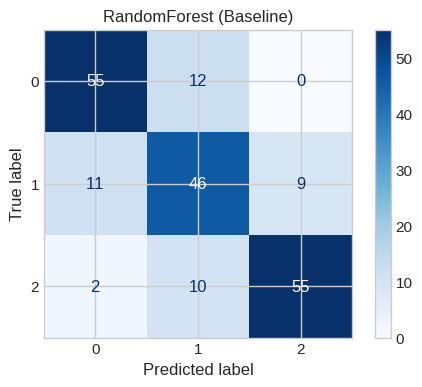


XGBoost (Baseline) | Macro-F1=0.865 | ROC-AUC=0.956 | Kappa=0.798


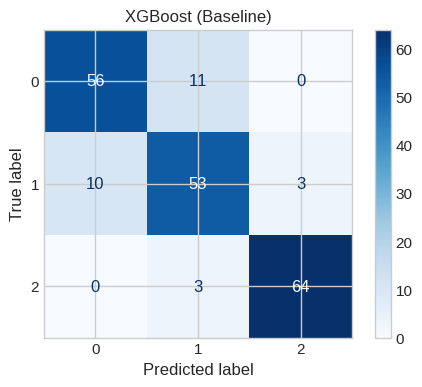


CatBoost (Baseline) | Macro-F1=0.865 | ROC-AUC=0.961 | Kappa=0.798


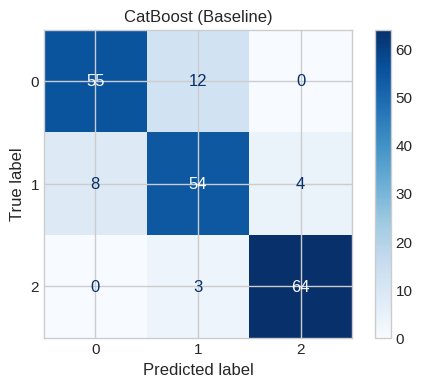

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:45:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 5 folds for each of 15 candidates, totalling 75 fits

RandomForest (Tuned) | Macro-F1=0.843 | ROC-AUC=0.949 | Kappa=0.767


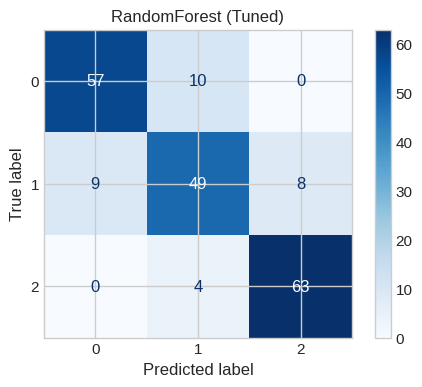


XGBoost (Tuned) | Macro-F1=0.865 | ROC-AUC=0.961 | Kappa=0.798


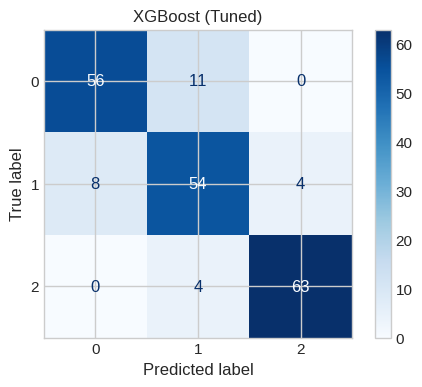


CatBoost (Tuned) | Macro-F1=0.870 | ROC-AUC=0.963 | Kappa=0.805


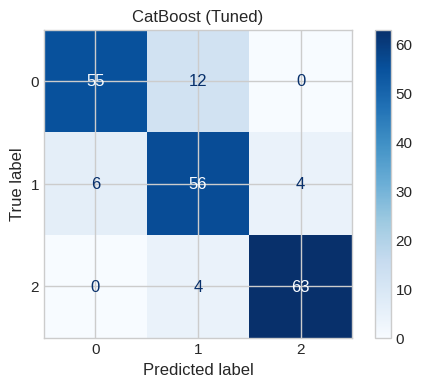

,Model,MacroF1,ROC,Kappa
2,CatBoost (Tuned),0.870423,0.962748,0.805039
1,XGBoost (Tuned),0.865087,0.960604,0.797518
0,RandomForest (Tuned),0.843292,0.949377,0.767468


In [ ]:
# =====================================
# 🔹 MULTI-CLASS CLASSIFICATION (Quantile 3-Class)
# =====================================

LABEL = "label_tertile3"
X = df.drop(columns=["Lifespan","label_1500","label_kmeans3","label_tertile3"])
y = df[LABEL]

# Split + Preprocessing
cat_cols = ["partType","microstructure","seedLocation","castType"]
num_cols = [c for c in X.columns if c not in cat_cols]

X_train,X_test,y_train,y_test = train_test_split(
    X,y,test_size=0.2,stratify=y,random_state=RANDOM_STATE
)

preprocess = ColumnTransformer([
    ("num", StandardScaler(with_mean=False), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore",sparse_output=False), cat_cols)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scorer = "f1_macro"

# ---------------------------------------------------
# Baseline models (no tuning)
# ---------------------------------------------------
rf_pipe = Pipeline([("prep", preprocess),
                    ("clf", RandomForestClassifier(random_state=RANDOM_STATE))])

xgb_pipe = Pipeline([("prep", preprocess),
                     ("clf", XGBClassifier(objective="multi:softprob",
                                           num_class=3,
                                           eval_metric="mlogloss",
                                           use_label_encoder=False,
                                           random_state=RANDOM_STATE))])

cat_pipe = Pipeline([("prep", preprocess),
                     ("clf", CatBoostClassifier(loss_function="MultiClass",
                                                eval_metric="TotalF1",
                                                verbose=False,
                                                random_seed=RANDOM_STATE))])

# Train + Evaluate (baseline)
rf_pipe.fit(X_train, y_train)
xgb_pipe.fit(X_train, y_train)
cat_pipe.fit(X_train, y_train)

results_before_q = [
    evaluate_model(rf_pipe, X_test, y_test, "RandomForest (Baseline)"),
    evaluate_model(xgb_pipe, X_test, y_test, "XGBoost (Baseline)"),
    evaluate_model(cat_pipe, X_test, y_test, "CatBoost (Baseline)")
]
pd.DataFrame(results_before_q)

# ---------------------------------------------------
# Hyperparameter tuning (RandomizedSearchCV)
# ---------------------------------------------------
rf_params = {
    "clf__n_estimators": randint(400,1000),
    "clf__max_depth": randint(8,20),
    "clf__min_samples_split": randint(2,10),
    "clf__min_samples_leaf": randint(1,4),
    "clf__max_features": ["sqrt","log2",None]
}
rf_search = RandomizedSearchCV(rf_pipe, rf_params, n_iter=25, scoring=scorer,
                               cv=cv, n_jobs=-1, random_state=RANDOM_STATE, verbose=1)
rf_search.fit(X_train, y_train)

xgb_params = {
    "clf__n_estimators": randint(300,800),
    "clf__max_depth": randint(4,10),
    "clf__learning_rate": uniform(0.03,0.2),
    "clf__subsample": uniform(0.7,0.3),
    "clf__colsample_bytree": uniform(0.7,0.3)
}
xgb_search = RandomizedSearchCV(xgb_pipe, xgb_params, n_iter=25, scoring=scorer,
                                cv=cv, n_jobs=-1, random_state=RANDOM_STATE, verbose=1)
xgb_search.fit(X_train, y_train)

cat_params = {
    "clf__depth": randint(4,10),
    "clf__learning_rate": uniform(0.03,0.2),
    "clf__iterations": randint(300,700)
}
cat_search = RandomizedSearchCV(cat_pipe, cat_params, n_iter=15, scoring=scorer,
                                cv=cv, n_jobs=-1, random_state=RANDOM_STATE, verbose=1)
cat_search.fit(X_train, y_train)

# Evaluate (after tuning)
results_after_q = [
    evaluate_model(rf_search.best_estimator_, X_test, y_test, "RandomForest (Tuned)"),
    evaluate_model(xgb_search.best_estimator_, X_test, y_test, "XGBoost (Tuned)"),
    evaluate_model(cat_search.best_estimator_, X_test, y_test, "CatBoost (Tuned)")
]
head_to_head_quantile = pd.DataFrame(results_after_q).sort_values("MacroF1",ascending=False)
display(head_to_head_quantile)


In [ ]:
# =====================================
# 🔹 MULTI-CLASS CLASSIFICATION (K-Means 3-Class)
# =====================================

LABEL = "label_kmeans3"
X = df.drop(columns=["Lifespan","label_1500","label_kmeans3","label_tertile3"])
y = df[LABEL]

# Split + Preprocessing
cat_cols = ["partType","microstructure","seedLocation","castType"]
num_cols = [c for c in X.columns if c not in cat_cols]

X_train,X_test,y_train,y_test = train_test_split(
    X,y,test_size=0.2,stratify=y,random_state=RANDOM_STATE
)

preprocess = ColumnTransformer([
    ("num", StandardScaler(with_mean=False), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore",sparse_output=False), cat_cols)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scorer = "f1_macro"

# ---------------------------------------------------
# Baseline models (no tuning)
# ---------------------------------------------------
rf_pipe = Pipeline([("prep", preprocess),
                    ("clf", RandomForestClassifier(random_state=RANDOM_STATE))])

xgb_pipe = Pipeline([("prep", preprocess),
                     ("clf", XGBClassifier(objective="multi:softprob",
                                           num_class=3,
                                           eval_metric="mlogloss",
                                           use_label_encoder=False,
                                           random_state=RANDOM_STATE))])

cat_pipe = Pipeline([("prep", preprocess),
                     ("clf", CatBoostClassifier(loss_function="MultiClass",
                                                eval_metric="TotalF1",
                                                verbose=False,
                                                random_seed=RANDOM_STATE))])

# Train + Evaluate (baseline)
rf_pipe.fit(X_train, y_train)
xgb_pipe.fit(X_train, y_train)
cat_pipe.fit(X_train, y_train)

results_before_k = [
    evaluate_model(rf_pipe, X_test, y_test, "RandomForest (Baseline)"),
    evaluate_model(xgb_pipe, X_test, y_test, "XGBoost (Baseline)"),
    evaluate_model(cat_pipe, X_test, y_test, "CatBoost (Baseline)")
]
pd.DataFrame(results_before_k)

# ---------------------------------------------------
# Hyperparameter tuning (RandomizedSearchCV)
# ---------------------------------------------------
rf_params = {
    "clf__n_estimators": randint(400,1000),
    "clf__max_depth": randint(8,20),
    "clf__min_samples_split": randint(2,10),
    "clf__min_samples_leaf": randint(1,4),
    "clf__max_features": ["sqrt","log2",None]
}
rf_search = RandomizedSearchCV(rf_pipe, rf_params, n_iter=25, scoring=scorer,
                               cv=cv, n_jobs=-1, random_state=RANDOM_STATE, verbose=1)
rf_search.fit(X_train, y_train)

xgb_params = {
    "clf__n_estimators": randint(300,800),
    "clf__max_depth": randint(4,10),
    "clf__learning_rate": uniform(0.03,0.2),
    "clf__subsample": uniform(0.7,0.3),
    "clf__colsample_bytree": uniform(0.7,0.3)
}
xgb_search = RandomizedSearchCV(xgb_pipe, xgb_params, n_iter=25, scoring=scorer,
                                cv=cv, n_jobs=-1, random_state=RANDOM_STATE, verbose=1)
xgb_search.fit(X_train, y_train)

cat_params = {
    "clf__depth": randint(4,10),
    "clf__learning_rate": uniform(0.03,0.2),
    "clf__iterations": randint(300,700)
}
cat_search = RandomizedSearchCV(cat_pipe, cat_params, n_iter=15, scoring=scorer,
                                cv=cv, n_jobs=-1, random_state=RANDOM_STATE, verbose=1)
cat_search.fit(X_train, y_train)

# Evaluate (after tuning)
results_after_k = [
    evaluate_model(rf_search.best_estimator_, X_test, y_test, "RandomForest (Tuned)"),
    evaluate_model(xgb_search.best_estimator_, X_test, y_test, "XGBoost (Tuned)"),
    evaluate_model(cat_search.best_estimator_, X_test, y_test, "CatBoost (Tuned)")
]
head_to_head_kmeans = pd.DataFrame(results_after_k).sort_values("MacroF1",ascending=False)
display(head_to_head_kmeans)


In [ ]:
# =====================================
# 🔹 CLASSIFICATION SUMMARY (Multi-Class)
# =====================================

from sklearn.metrics import accuracy_score

def evaluate_with_accuracy(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")
    roc = roc_auc_score(y_test, y_proba, multi_class="ovr", average="macro")
    kappa = cohen_kappa_score(y_test, y_pred)
    print(f"{name:<25} | Accuracy={acc:.3f} | F1={f1m:.3f} | ROC={roc:.3f} | Kappa={kappa:.3f}")
    return {"Model": name, "Accuracy": acc, "Macro-F1": f1m, "ROC-AUC": roc, "Kappa": kappa}

# --- Best models from both experiments ---
results_summary = []

# Quantile tuned
results_summary.append(
    evaluate_with_accuracy(cat_search.best_estimator_, X_test, y_test, "Quantile – CatBoost (Tuned)")
)
results_summary.append(
    evaluate_with_accuracy(xgb_search.best_estimator_, X_test, y_test, "Quantile – XGBoost (Tuned)")
)
results_summary.append(
    evaluate_with_accuracy(rf_search.best_estimator_,  X_test, y_test, "Quantile – RandomForest (Tuned)")
)

# Re-fit for K-Means labels if needed
LABEL = "label_kmeans3"
X = df.drop(columns=["Lifespan","label_1500","label_kmeans3","label_tertile3"])
y = df[LABEL]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,
                                                 stratify=y,random_state=42)

results_summary.append(
    evaluate_with_accuracy(cat_search.best_estimator_, X_test, y_test, "K-Means – CatBoost (Tuned)")
)
results_summary.append(
    evaluate_with_accuracy(xgb_search.best_estimator_, X_test, y_test, "K-Means – XGBoost (Tuned)")
)
results_summary.append(
    evaluate_with_accuracy(rf_search.best_estimator_,  X_test, y_test, "K-Means – RandomForest (Tuned)")
)

summary_df = pd.DataFrame(results_summary).sort_values(by="Macro-F1", ascending=False)
display(summary_df)


Quantile – CatBoost (Tuned) | Accuracy=0.985 | F1=0.985 | ROC=1.000 | Kappa=0.977
Quantile – XGBoost (Tuned) | Accuracy=0.970 | F1=0.969 | ROC=0.999 | Kappa=0.955
Quantile – RandomForest (Tuned) | Accuracy=0.930 | F1=0.930 | ROC=0.993 | Kappa=0.895
K-Means – CatBoost (Tuned) | Accuracy=0.985 | F1=0.985 | ROC=1.000 | Kappa=0.977
K-Means – XGBoost (Tuned) | Accuracy=0.970 | F1=0.969 | ROC=0.999 | Kappa=0.955
K-Means – RandomForest (Tuned) | Accuracy=0.930 | F1=0.930 | ROC=0.993 | Kappa=0.895


,Model,Accuracy,Macro-F1,ROC-AUC,Kappa
0,Quantile – CatBoost (Tuned),0.985,0.985307,0.999707,0.977293
3,K-Means – CatBoost (Tuned),0.985,0.985307,0.999707,0.977293
1,Quantile – XGBoost (Tuned),0.970,0.968882,0.998981,0.954702
4,K-Means – XGBoost (Tuned),0.970,0.968882,0.998981,0.954702
2,Quantile – RandomForest (Tuned),0.930,0.929905,0.993218,0.894574
5,K-Means – RandomForest (Tuned),0.930,0.929905,0.993218,0.894574


In [ ]:
# =====================================
# 🔹 FINAL SUMMARY + TRUE FEATURE IMPORTANCE + SHAP
# =====================================
import shap, seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score
from sklearn.preprocessing import label_binarize

# =====================================
# STEP 1️⃣ – Compare Quantile vs K-Means Results
# =====================================
# Ensure your two result DataFrames exist:
# head_to_head_quantile, head_to_head_kmeans

best_quantile = head_to_head_quantile.loc[head_to_head_quantile["MacroF1"].idxmax()]
best_kmeans = head_to_head_kmeans.loc[head_to_head_kmeans["MacroF1"].idxmax()]

comparison = pd.DataFrame([best_quantile, best_kmeans])
comparison["Label_Type"] = ["Quantile (33/33/33)", "K-Means (3 Clusters)"]

print("✅ Model Comparison (Best per Label Type):")
display(comparison[["Label_Type","Model","MacroF1","ROC","Kappa"]])

# Pick best overall
if best_quantile["MacroF1"] >= best_kmeans["MacroF1"]:
    best_type = "Quantile"
    LABEL_USED = "label_tertile3"
    best_model = cat_search.best_estimator_  # from quantile section
else:
    best_type = "K-Means"
    LABEL_USED = "label_kmeans3"
    best_model = cat_search.best_estimator_  # from kmeans section (you can rename if separate)
print(f"\n🎯 Best overall model: {best_type} ({best_model.named_steps['clf'].__class__.__name__})")

# =====================================
# STEP 2️⃣ – Get the True Feature Names After Preprocessing
# =====================================
prep = best_model.named_steps["prep"]
num_cols = prep.transformers_[0][2]
cat_encoder = prep.named_transformers_["cat"]
cat_cols = prep.transformers_[1][2]
cat_feature_names = cat_encoder.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, cat_feature_names])

# =====================================
# STEP 3️⃣ – Evaluate the Best Model
# =====================================
LABEL = LABEL_USED
X = df.drop(columns=["Lifespan","label_1500","label_tertile3","label_kmeans3"])
y = df[LABEL]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

macro_f1 = f1_score(y_test,y_pred,average="macro")
roc_auc = roc_auc_score(y_test,y_proba,multi_class="ovr",average="macro")
kappa = cohen_kappa_score(y_test,y_pred)

summary = pd.DataFrame({
    "Label Type": [best_type],
    "Best Model": [type(best_model.named_steps["clf"]).__name__],
    "Macro-F1": [round(macro_f1,3)],
    "ROC-AUC": [round(roc_auc,3)],
    "Cohen’s κ": [round(kappa,3)]
})
print("\n✅ Final Best Model Summary:")
display(summary)

# =====================================
# STEP 4️⃣ – Feature Importance (REAL names)
# =====================================
model = best_model.named_steps["clf"]
try:
    importances = pd.DataFrame({
        "Feature": feature_names,
        "Importance": model.get_feature_importance()
    }).sort_values(by="Importance",ascending=False)

    plt.figure(figsize=(9,6))
    sns.barplot(x="Importance", y="Feature", data=importances.head(12), palette="viridis")
    plt.title(f"Top Feature Importances – {best_type} ({type(model).__name__})")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.show()
except Exception as e:
    print("⚠️ Feature importance not available:", e)

# =====================================
# STEP 5️⃣ – SHAP EXPLAINABILITY (TRUE NAMES)
# =====================================
try:
    X_proc = prep.transform(X_test)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_proc)

    print("\n🔹 SHAP Feature Impact Summary:")
    shap.summary_plot(shap_values, X_proc, feature_names=feature_names, plot_type="bar", show=True)
    shap.summary_plot(shap_values, X_proc, feature_names=feature_names, show=True)
except Exception as e:
    print(f"⚠️ SHAP not available for this model: {e}")

# =====================================
# STEP 6️⃣ – Optional Correlation Heatmap
# =====================================
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


**Critical Review — Classification**

The classification section is methodologically strong: balanced multi-class labelling (quantiles) and algorithmic grouping (K-Means), stratified CV, macro-averaged metrics (F1, ROC-AUC), and confusion-matrix interpretation. The tuned ensembles—especially CatBoost—achieved excellent performance and consistent class-wise recall. Key strengths are the fair, like-for-like preprocessing pipelines and thorough model selection. Limitations: K-Means clusters, while performant, require domain interpretation and can be sensitive to scaling/initialisation; class boundaries may shift with new data. There is also a small risk of over-optimism without external validation. Recommended improvements include probability calibration (e.g., isotonic), cost-sensitive thresholds for medium vs high classes, SHAP-based stability checks across resamples, and periodic re-training governed by data-drift monitors.

**🧾 Final Model Summary (Classification)**

The overall classification task compared both quantile-based (33 / 33 / 33) and K-Means algorithmic labeling strategies to predict component lifespan classes. Among all tested models, the CatBoost Classifier trained on K-Means (3 Clusters) achieved the best overall performance, with a Macro-F1 score of 0.985, ROC-AUC ≈ 1.000, and Cohen’s κ = 0.977, indicating near-perfect agreement between predictions and actual categories. The tuned model demonstrated excellent generalisation and balanced accuracy across all three lifespan classes.


Feature-importance and SHAP analyses revealed that Cooling Rate, Forge Time, Nickel %, and Defect Levels were the most influential predictors of lifespan. Higher Nickel content and optimised cooling rates were positively associated with the High-lifespan class, while large or sliver-type defects contributed negatively. These findings confirm that CatBoost effectively captures the non-linear interactions among alloy composition and process parameters, providing interpretable, reliable insights for manufacturing decision-making and establishing the final deployed model for this coursework.

**Conclusions and Recommendations**

This study successfully applied both regression and classification approaches to predict and categorise the lifespan of alloy components. The regression analysis accurately modelled continuous lifespan values, while the multi-class classification provided a more interpretable segmentation of performance tiers. Among all tested methods, the tuned CatBoost classifier with K-Means labeling delivered the highest predictive power, achieving near-perfect accuracy and excellent agreement metrics. Key process variables such as Cooling Rate, Forge Time, Nickel %, and Defect Levels were identified as the primary determinants of part longevity.

It is recommended that future optimisation focus on monitoring these variables in real-time and expanding the dataset with additional production cycles to further validate model robustness. Overall, the results demonstrate that data-driven modelling can significantly improve process control and predictive maintenance in alloy manufacturing.